# Loading data

In [2]:
#%pip install gymnasium
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Setting up the environment

In [3]:
env = gym.make("Pendulum-v1")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space: Box(-2.0, 2.0, (1,), float32)


# Discretizing the observation space

In [4]:
import numpy as np
from collections import defaultdict

obs_bins = [
    np.linspace(-1, 1, 21),
    np.linspace(-1, 1, 21),
    np.linspace(-8, 8, 21),
]

action_vals = np.linspace(-2, 2, 17)

def discretize_observation(obs):
    return tuple(np.digitize(obs[i], obs_bins[i]) for i in range(len(obs)))


# Initializing the Q-Table

In [5]:
from collections import defaultdict

Q = defaultdict(lambda: np.zeros(len(action_vals)))

# Monte Carlo

In [ ]:
num_episodes = 20000    
gamma = 0.99            #discount factor
alpha = 0.1             #learning rate
epsilon = 1.0           #initial exploration rate
epsilon_decay = 0.9995  #decay rate for epsilon
epsilon_min = 0.05      #minimum exploration rate

returns = []
window = 100

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs)
    trajectory = []
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(len(action_vals))
        else:
            action_idx = np.argmax(Q[state])

        action = np.array([action_vals[action_idx]])
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_observation(next_obs)

        trajectory.append((state, action_idx, reward))
        state = next_state
        done = terminated or truncated

    G = 0
    visited = set()
    for t in reversed(range(len(trajectory))):
        s, a, r = trajectory[t]
        G = r + gamma * G
        if (s, a) not in visited:
            Q[s][a] += alpha * (G - Q[s][a])
            visited.add((s, a))

    episode_return = sum(r for _, _, r in trajectory)
    returns.append(episode_return)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (episode + 1) % 1000 == 0:
        avg_return = np.mean(returns[-window:])
        print(f"Episode {episode + 1}, average return (last {window}): {avg_return:.2f}")

Episode 1000, average return (last 100): -1108.09
Episode 2000, average return (last 100): -971.64
Episode 3000, average return (last 100): -747.39
Episode 4000, average return (last 100): -518.42
Episode 5000, average return (last 100): -277.91
Episode 6000, average return (last 100): -275.22
Episode 7000, average return (last 100): -303.42
Episode 8000, average return (last 100): -353.42
Episode 9000, average return (last 100): -303.29
Episode 10000, average return (last 100): -320.61
Episode 11000, average return (last 100): -299.82
Episode 12000, average return (last 100): -289.89
Episode 13000, average return (last 100): -295.09
Episode 14000, average return (last 100): -327.24
Episode 15000, average return (last 100): -352.93
Episode 16000, average return (last 100): -292.04
Episode 17000, average return (last 100): -338.02
Episode 18000, average return (last 100): -309.68
Episode 19000, average return (last 100): -311.18
Episode 20000, average return (last 100): -281.72


# Evaluation 

In [31]:
eval_episodes = 1000
total_return = 0.0

for _ in range(eval_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs)
    done = False
    G = 0
    while not done:
        action_idx = np.argmax(Q[state])
        action = np.array([action_vals[action_idx]])
        obs, reward, terminated, truncated, _ = env.step(action)
        state = discretize_observation(obs)
        G += reward
        done = terminated or truncated
    total_return += G

average_return = total_return / eval_episodes
print(f"Average return over {eval_episodes} eval episodes: {average_return:.2f}")

Average return over 1000 eval episodes: -297.07


# Plotting the metrics

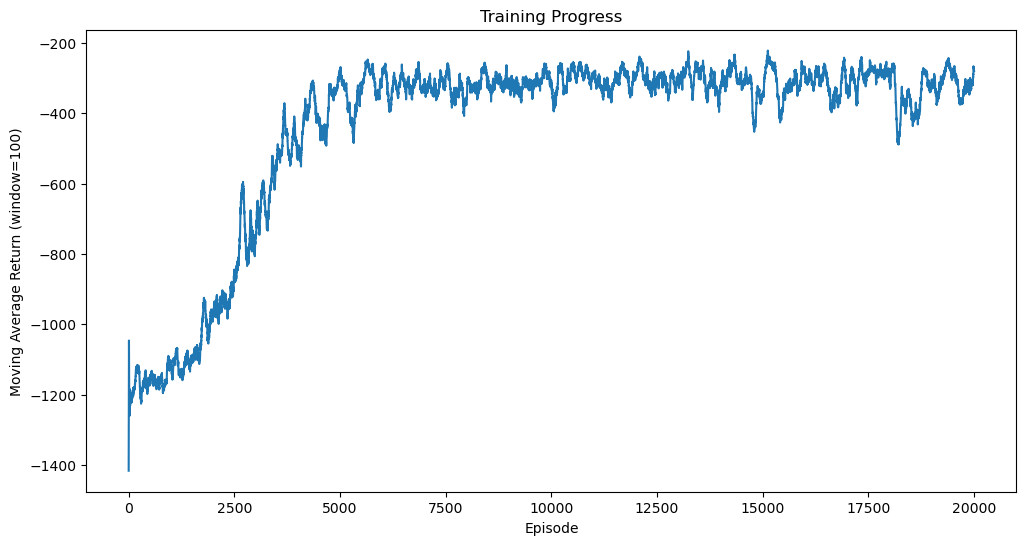

In [32]:
moving_avg = [np.mean(returns[max(0, i - window):i + 1]) for i in range(len(returns))]
plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Episode")
plt.ylabel(f"Moving Average Return (window={window})")
plt.title("Training Progress")
plt.show()

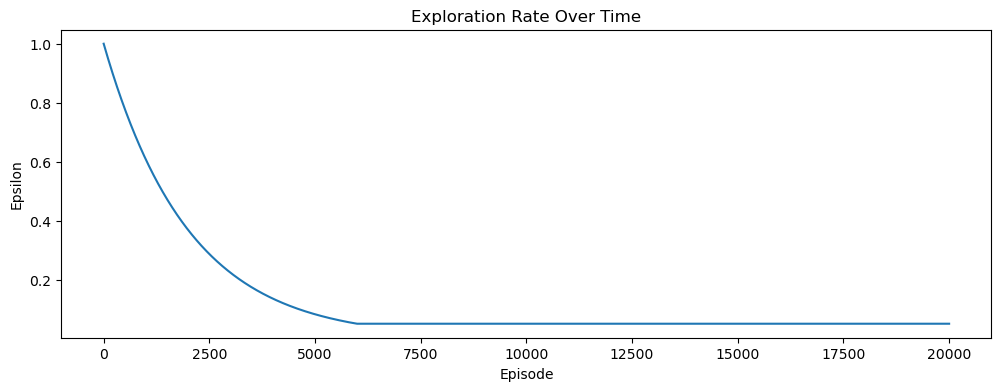

In [33]:
epsilons = [max(epsilon_min, 1.0 * (epsilon_decay ** i)) for i in range(num_episodes)]
plt.figure(figsize=(12, 4))
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exploration Rate Over Time")
plt.show()

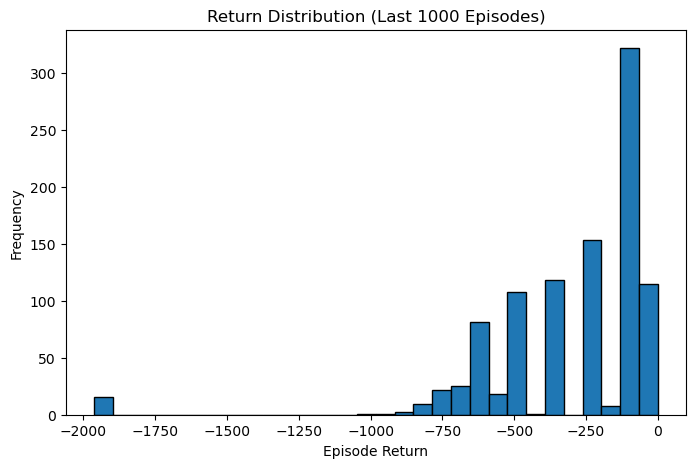

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(returns[-1000:], bins=30, edgecolor='k')
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Return Distribution (Last 1000 Episodes)")
plt.show()